# **🧬 Automated Detection of Bacterial Flagellar Motors in Cryo-Electron Tomograms**

## **Background**
The **flagellar motor** is a remarkable molecular machine responsible for the motility of many microorganisms. It plays a critical role in biological processes such as **chemotaxis** (movement in response to chemical stimuli) and **pathogenesis** (the development of disease).

## **Imaging with Cryo-Electron Tomography (Cryo-ET)**
**Cryogenic electron tomography (cryo-ET)** is a powerful imaging technique that enables visualization of cellular structures in near-native conditions. It reconstructs 3D images (tomograms) from a series of 2D projections, providing detailed views of intracellular components like the flagellar motor.

## **Challenge**
Despite its capabilities, cryo-ET presents several challenges for automated analysis:
- **Low signal-to-noise ratio**
- **Variable orientations** of the flagellar motor
- **Complex and crowded intracellular environments**

These factors make manual annotation necessary, creating a **bottleneck** in the analysis pipeline and limiting scalability.

## **Objective**
The goal of this task is to develop an **image processing algorithm** that can:
- Automatically identify the **presence and location** of a flagellar motor within a tomogram.
- Reduce reliance on manual intervention and improve processing efficiency.

## **About the Data**
- Each **tomogram** is a 3D reconstruction created from multiple 2D electron microscopy images.
- The bacterial samples were **flash-frozen** in ice to preserve their native molecular structures.

# **This is part 2 of the notebook focusing on model training**

In [2]:
!pip install ultralytics

In [3]:
import numpy as np
import pandas as pd
import yaml
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle
from ultralytics import YOLO
import json
import matplotlib.pyplot as plt
import torch

In [4]:
if torch.cuda.is_available():
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")


Number of CUDA devices: 2
Device 0: Tesla T4
Device 1: Tesla T4


## **Initializing Project**

In [ ]:
yolo_dataset_dir = "/kaggle/input/byu-bacteria-8-bit-dataset/yolo_dataset" # Path to dataset after preprocessing
yolo_weights_dir = "/kaggle/working/yolo_weights"
yolo_pretrained_weights = "/kaggle/input/yolov8_default/other/2/1/yolov8m.pt"  # Path to pre-downloaded weights

# Create weights directory if it doesn't exist
os.makedirs(yolo_weights_dir, exist_ok=True)

### **Function: `fix_yaml_paths`**

This function updates the dataset path in a YOLO-style `.yaml` configuration file to make it compatible with the **Kaggle working directory structure**. This is often necessary when transferring data between local environments and cloud platforms like Kaggle.

#### **What it does:**
- Loads the original YAML file used for YOLO training.
- Updates the `path` field to point to the current dataset directory (`yolo_dataset_dir`).
- Saves the modified YAML to a new file: `fixed_dataset.yaml` in the `/kaggle/working/` directory.
- Returns the path to the fixed YAML file for use in training scripts.

---

### **Function: `plot_dfl_loss_curve`**

This function visualizes the **Distribution Focal Loss (DFL)** curves from a YOLO training run by reading the `results.csv` file.

#### **What it does:**
- Searches for `train/dfl_loss` and `val/dfl_loss` columns in the training logs.
- Plots both loss curves over training epochs.
- Identifies and marks the **epoch with the lowest validation DFL loss**, which typically corresponds to the best-performing model.
- Saves the plot to both the specified `run_dir` and `/kaggle/working/` for easy access.

#### **Why this is useful:**
- Helps evaluate **model convergence** and **generalization performance**.
- Provides a clear visualization of training progress and the point of best validation performance.

In [6]:
def fix_yaml_paths(yaml_path):
    """Fix paths in a YAML file for Kaggle directories."""
    with open(yaml_path, 'r') as f:
        yaml_data = yaml.safe_load(f)

    yaml_data['path'] = yolo_dataset_dir if 'path' in yaml_data else yaml_data.get('path')

    fixed_yaml_path = "/kaggle/working/fixed_dataset.yaml"
    with open(fixed_yaml_path, 'w') as f:
        yaml.dump(yaml_data, f)

    print(f"Fixed YAML saved at {fixed_yaml_path} with path: {yaml_data.get('path')}")
    return fixed_yaml_path

def plot_dfl_loss_curve(run_dir):
    """Plot train/validation DFL loss curves and mark the best model."""
    results_csv = os.path.join(run_dir, 'results.csv')
    if not os.path.exists(results_csv):
        print(f"Results file not found: {results_csv}")
        return

    results_df = pd.read_csv(results_csv)
    train_col = next((col for col in results_df if 'train/dfl_loss' in col), None)
    val_col = next((col for col in results_df if 'val/dfl_loss' in col), None)
    
    if not train_col or not val_col:
        print("DFL loss columns not found. Available columns:", results_df.columns.tolist())
        return

    best_epoch = results_df[val_col].idxmin()
    best_val_loss = results_df.at[best_epoch, val_col]

    plt.figure(figsize=(10, 6))
    plt.plot(results_df['epoch'], results_df[train_col], label='Train DFL Loss')
    plt.plot(results_df['epoch'], results_df[val_col], label='Validation DFL Loss')
    plt.axvline(results_df.at[best_epoch, 'epoch'], color='r', linestyle='--',
                label=f'Best Model (Epoch {int(results_df.at[best_epoch, "epoch"])}, Val Loss: {best_val_loss:.4f})')

    plt.xlabel('Epoch')
    plt.ylabel('DFL Loss')
    plt.title('Training and Validation DFL Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    for path in [run_dir, '/kaggle/working']:
        plt.savefig(os.path.join(path, 'dfl_loss_curve.png'))

    print(f"Loss curve saved to {run_dir}/dfl_loss_curve.png")
    plt.close()

    return best_epoch, best_val_loss

### **Function: `train_yolo_model`**

This function trains a **YOLOv8 model** on the prepared dataset using a given configuration and pre-trained weights.

#### **Key Features:**
- Loads a YOLO model initialized with **pre-trained weights**.
- Trains the model using the dataset defined in the provided **YAML configuration file**.
- Applies **early stopping** (patience = 10) to prevent overfitting.
- Saves training checkpoints every 5 epochs.
- Generates and saves a **DFL loss curve** to visualize training progress.
- Prints details about the **best-performing epoch** based on validation loss.

In [15]:
def train_yolo_model(yaml_path, pretrained_weights_path, epochs=30, batch_size=16, img_size=640):
    """
    Train a YOLO model on the prepared dataset
    
    Args:
        yaml_path (str): Path to the dataset YAML file
        pretrained_weights_path (str): Path to pre-downloaded weights file
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        img_size (int): Image size for training
    """
    print(f"Loading pre-trained weights from: {pretrained_weights_path}")
    
    # Load a pre-trained YOLOv8 model
    model = YOLO(pretrained_weights_path)
    
    # Train the model with early stopping
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        batch=batch_size,
        imgsz=img_size,
        project=yolo_weights_dir,
        name='motor_detector',
        exist_ok=True,
        patience=10,              # Early stopping if no improvement for 5 epochs
        save_period=5,           # Save checkpoints every 5 epochs
        val=True,                # Ensure validation is performed
        verbose=True             # Show detailed output during training
    )
    
    # Get the path to the run directory
    run_dir = os.path.join(yolo_weights_dir, 'motor_detector')
    
    # Plot and save the loss curve
    best_epoch_info = plot_dfl_loss_curve(run_dir)
    
    if best_epoch_info:
        best_epoch, best_val_loss = best_epoch_info
        print(f"\nBest model found at epoch {best_epoch} with validation DFL loss: {best_val_loss:.4f}")
    
    return model, results


In [8]:
def predict_on_samples(model, num_samples=4):
    """Run predictions on random validation samples and display results."""
    val_dir = next((d for d in [os.path.join(yolo_dataset_dir, 'images', sub) for sub in ['val', 'train']] if os.path.exists(d)), None)
    
    if not val_dir or not (val_images := os.listdir(val_dir)):
        print("No images found for prediction")
        return
    
    samples = random.sample(val_images, min(num_samples, len(val_images)))
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    for ax, img_file in zip(axes.flatten(), samples):
        img_path = os.path.join(val_dir, img_file)
        img = Image.open(img_path)
        ax.imshow(np.array(img), cmap='gray')

        results = model.predict(img_path, conf=0.25)[0]

        # Draw ground truth box if filename format supports it
        try:
            parts = {p[0]: int(p[1:].split('.')[0]) for p in img_file.split('_') if p[0] in 'xy'}
            if 'x' in parts and 'y' in parts:
                ax.add_patch(Rectangle((parts['x']-12, parts['y']-12), 24, 24, edgecolor='g', facecolor='none'))
        except:
            pass
        
        # Draw predicted boxes
        for (x1, y1, x2, y2), conf in zip(results.boxes.xyxy.cpu().numpy(), results.boxes.conf.cpu().numpy()):
            ax.add_patch(Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='r', facecolor='none'))
            ax.text(x1, y1-5, f'{conf:.2f}', color='red')
        
        ax.set_title(f"{img_file}\nGround Truth (green) vs Prediction (red)")
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/predictions.png')
    plt.show()


In [9]:
import os
import yaml

def prepare_dataset():
    """Check dataset existence and create/fix YAML if needed."""
    
    yaml_path = os.path.join(yolo_dataset_dir, 'dataset.yaml')
    
    if os.path.exists(yaml_path):
        return fix_yaml_paths(yaml_path)

    # Create new YAML if missing
    yaml_data = {
        'path': yolo_dataset_dir,
        'train': 'images/train',
        'val': 'images/val',
        'names': {0: 'motor'}
    }

    new_yaml_path = "/kaggle/working/dataset.yaml"
    with open(new_yaml_path, 'w') as f:
        yaml.dump(yaml_data, f)

    print(f"Created new YAML at {new_yaml_path}")
    return new_yaml_path

Below is the **entry point** for running the full YOLO training pipeline. It orchestrates the dataset preparation, model training, and post-training prediction steps.

#### **Highlights:**
- Automates the end-to-end training process.
- Displays the content of the YAML file for verification.
- Uses 100 training epochs by default.
- Provides visual feedback with sample predictions after training.

Starting YOLO training process...
Fixed YAML saved at /kaggle/working/fixed_dataset.yaml with path: /kaggle/input/byu-bacteria-8-bit-dataset/yolo_dataset
Using YAML file:
names:
  0: motor
path: /kaggle/input/byu-bacteria-8-bit-dataset/yolo_dataset
train: images/train
val: images/val


Starting YOLO training...
Loading pre-trained weights from: /kaggle/input/yolov8_default/other/2/1/yolov8m.pt
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/yolov8_default/other/2/1/yolov8m.pt, data=/kaggle/working/fixed_dataset.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=None, workers=8, project=/kaggle/working/yolo_weights, name=motor_detector, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

train: Scanning /kaggle/input/byu-bacteria-8-bit-dataset/yolo_dataset/labels/train... 3262 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3262/3262 [00:03<00:00, 867.78it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/byu-bacteria-8-bit-dataset/yolo_dataset/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/input/byu-bacteria-8-bit-dataset/yolo_dataset/labels/val... 792 images, 0 backgrounds, 0 corrupt: 100%|██████████| 792/792 [00:01<00:00, 719.72it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/byu-bacteria-8-bit-dataset/yolo_dataset/labels is not writeable, cache not saved.


Plotting labels to /kaggle/working/yolo_weights/motor_detector/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/yolo_weights/motor_detector
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.34G      3.258      6.634      1.285         20        640: 100%|██████████| 204/204 [02:07<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


                   all        792        792      0.232      0.201      0.101     0.0177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.26G      2.547      2.144      1.046         14        640: 100%|██████████| 204/204 [02:03<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]

                   all        792        792      0.415       0.39      0.307     0.0735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.26G      2.402      1.924      1.014         18        640: 100%|██████████| 204/204 [02:02<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        792        792      0.632      0.624      0.572      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.27G      2.285      1.746     0.9946         13        640: 100%|██████████| 204/204 [02:02<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        792        792      0.441      0.326      0.235     0.0409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.27G      2.179      1.649      0.966         15        640: 100%|██████████| 204/204 [02:02<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]

                   all        792        792      0.648      0.551      0.532      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.27G      2.081       1.54     0.9549         27        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        792        792      0.713      0.673      0.669      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.27G      1.966      1.373     0.9358         18        640: 100%|██████████| 204/204 [02:01<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        792        792      0.544      0.456      0.395     0.0942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.27G      1.954      1.304     0.9301         11        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        792        792      0.666      0.653      0.608      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.27G      1.872      1.251     0.9171         13        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]

                   all        792        792      0.745      0.731      0.741      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.27G      1.837      1.175     0.9141         16        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]

                   all        792        792       0.81       0.73      0.782      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.27G      1.803      1.151      0.903         19        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        792        792      0.805      0.745      0.778      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.27G      1.735      1.086     0.8987         17        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]

                   all        792        792      0.797      0.777       0.79      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.27G      1.666      1.068     0.8905         21        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        792        792      0.799      0.737      0.771      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.27G      1.684      1.036      0.894         21        640: 100%|██████████| 204/204 [02:01<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        792        792      0.838      0.744      0.797      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.27G      1.616     0.9927     0.8749         18        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        792        792      0.824      0.793      0.821      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.27G      1.577     0.9827     0.8759         17        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]

                   all        792        792      0.839      0.734      0.793       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.27G      1.548     0.9795     0.8706         12        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        792        792       0.87      0.762      0.825      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.27G      1.514     0.9033     0.8632         13        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]

                   all        792        792      0.834      0.736      0.761      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.27G      1.479     0.8803     0.8612         21        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        792        792      0.836      0.799      0.835      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.27G      1.495     0.8813     0.8651          9        640: 100%|██████████| 204/204 [02:00<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        792        792      0.808      0.817      0.834      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.27G      1.401     0.8354     0.8539         18        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]

                   all        792        792      0.774      0.745      0.756      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.27G      1.426     0.8549     0.8521         26        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        792        792      0.823      0.803      0.849      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.27G      1.372     0.8169     0.8461         28        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        792        792      0.825      0.794      0.829      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.27G      1.401     0.8084     0.8451         22        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        792        792      0.846      0.818      0.855      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      9.27G      1.355     0.8109     0.8458         13        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        792        792      0.826      0.799      0.826      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.27G      1.334     0.7829     0.8404         17        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.06it/s]

                   all        792        792       0.84      0.809       0.84       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      9.27G      1.293     0.7647     0.8382         20        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]

                   all        792        792       0.85      0.813      0.846      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.27G      1.293     0.7713     0.8336         23        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        792        792      0.807      0.795      0.804      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      9.27G      1.265     0.7349      0.834         23        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        792        792      0.868      0.816      0.864      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.27G      1.286     0.7461     0.8327         12        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]

                   all        792        792      0.844      0.856      0.871      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.27G      1.236     0.7062     0.8342         25        640: 100%|██████████| 204/204 [02:00<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]

                   all        792        792      0.857      0.857       0.89      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.27G      1.219     0.7021     0.8268         23        640: 100%|██████████| 204/204 [02:01<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.06it/s]

                   all        792        792      0.832      0.824      0.835      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.27G      1.194     0.6956     0.8216         11        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        792        792      0.868      0.836      0.868      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.27G        1.2     0.6873     0.8281         19        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        792        792      0.847      0.804      0.846      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      9.27G      1.213     0.6987     0.8262         23        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.06it/s]

                   all        792        792      0.884      0.821      0.872      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      9.27G      1.133     0.6557     0.8226         30        640: 100%|██████████| 204/204 [02:00<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        792        792      0.841      0.847      0.873       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      9.27G      1.161     0.6628     0.8192         22        640: 100%|██████████| 204/204 [02:01<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        792        792      0.841      0.836      0.856      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      9.27G      1.127     0.6485      0.819         20        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        792        792       0.83      0.826      0.846      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.27G      1.153     0.6596     0.8217         23        640: 100%|██████████| 204/204 [02:01<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]

                   all        792        792      0.866      0.839      0.865      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.27G      1.107     0.6321     0.8142         22        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.07it/s]

                   all        792        792      0.859      0.843      0.862      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      9.27G      1.105      0.643     0.8172         17        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]

                   all        792        792      0.838      0.846      0.847      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.27G      1.074     0.6314     0.8135         23        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]

                   all        792        792      0.834       0.85       0.85      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      9.27G      1.077     0.6224     0.8102         20        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.06it/s]

                   all        792        792      0.845      0.845      0.873       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.27G      1.072     0.6083     0.8132         15        640: 100%|██████████| 204/204 [02:02<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]

                   all        792        792      0.834      0.823      0.852      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      9.27G       1.05     0.6044     0.8155         26        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.07it/s]

                   all        792        792      0.825      0.836      0.866       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      9.27G       1.05     0.5959     0.8122         20        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        792        792      0.841      0.829      0.867      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.27G      1.028     0.5872      0.813         14        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.07it/s]

                   all        792        792      0.847      0.825      0.852      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.27G      1.052     0.6014     0.8093         15        640: 100%|██████████| 204/204 [02:01<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        792        792      0.867      0.805      0.839      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.27G       1.05     0.5868     0.8127         15        640: 100%|██████████| 204/204 [02:01<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.07it/s]

                   all        792        792      0.852      0.832      0.843      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      9.27G          1     0.5603     0.8096         19        640: 100%|██████████| 204/204 [02:01<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        792        792      0.827      0.821      0.845      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.27G      1.032     0.5802     0.8137         16        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]

                   all        792        792      0.856      0.809      0.836      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.27G     0.9739     0.5614     0.8047         27        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.08it/s]

                   all        792        792       0.85      0.841      0.848      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.27G     0.9778     0.5644     0.8094         23        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.06it/s]

                   all        792        792      0.848      0.837      0.855      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      9.27G     0.9625     0.5495     0.8052         15        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]

                   all        792        792      0.869      0.841       0.87      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.27G     0.9703     0.5564     0.8027         24        640: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.06it/s]

                   all        792        792      0.855      0.835       0.84       0.32
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 45, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



55 epochs completed in 2.061 hours.
Optimizer stripped from /kaggle/working/yolo_weights/motor_detector/weights/last.pt, 52.0MB
Optimizer stripped from /kaggle/working/yolo_weights/motor_detector/weights/best.pt, 52.0MB

Validating /kaggle/working/yolo_weights/motor_detector/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


                   all        792        792      0.826      0.836      0.866       0.42


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 11.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/yolo_weights/motor_detector
Loss curve saved to /kaggle/working/yolo_weights/motor_detector/dfl_loss_curve.png

Best model found at epoch 44 with validation DFL loss: 0.8958

Training complete!

Running predictions on sample images...

image 1/1 /kaggle/input/byu-bacteria-8-bit-dataset/yolo_dataset/images/val/tomo_00e463_z0224_y0241_x0643.jpg: 640x640 2 motors, 18.0ms
Speed: 3.6ms preprocess, 18.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/byu-bacteria-8-bit-dataset/yolo_dataset/images/val/tomo_00e463_z0228_y0262_x0628.jpg: 640x640 2 motors, 17.8ms
Speed: 3.4ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/byu-bacteria-8-bit-dataset/yolo_dataset/images/val/tomo_656915_z0204_y0794_x0167.jpg: 640x640 1 motor, 19.3ms
Speed: 3.0ms preprocess, 19.3ms inference, 1.4ms

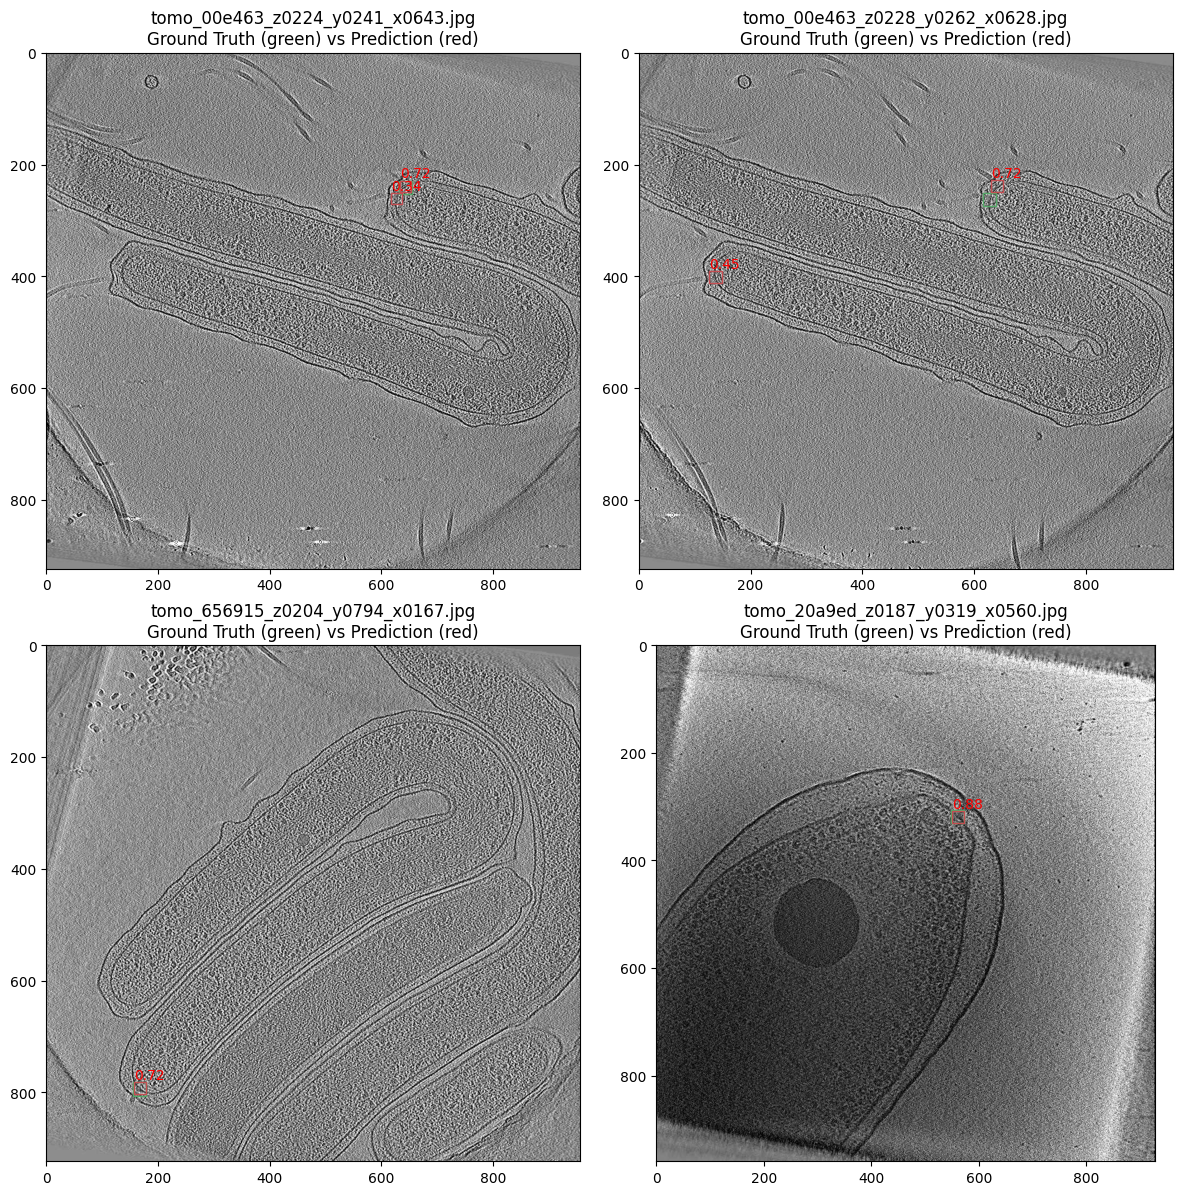

In [16]:
def main():
    print("Starting YOLO training process...")
    
    # Prepare dataset and get YAML path
    yaml_path = prepare_dataset()
    print(f"Using YAML file:\n{open(yaml_path).read()}")

    # Train model
    print("\nStarting YOLO training...")
    model, results = train_yolo_model(yaml_path, yolo_pretrained_weights, epochs=100)
    print("\nTraining complete!")

    # Run predictions
    print("\nRunning predictions on sample images...")
    predict_on_samples(model, num_samples=4)

main()

### ✅ **Best YOLOv8 Model Performance Summary**

- **Framework**: Ultralytics YOLOv8 (v8.3.102)  
- **Environment**: Python 3.10 · PyTorch 2.5.1 · CUDA-enabled (Tesla T4, 16 GB)

#### **Model Architecture**
- **Depth**: 92 layers  
- **Parameters**: 25.8 million  
- **Compute**: 78.7 GFLOPs  

#### **Validation Performance**
- **Dataset**: 792 images with 792 motor instances  
- **Results:**
  - **Precision**: 0.826  
  - **Recall**: 0.836  
  - **mAP@0.50**: 0.866  
  - **mAP@0.50:0.95**: 0.420  

This model shows strong localization performance with **high mAP@50** and balanced precision/recall—ideal for detecting motors in noisy tomographic slices.